# ML OPS 3

### This Markdown file shows important insights into the model registration process using ML FLow / Python.

This is crucial to track which model fits the required metrics best and ensures reproducibility! To this aim, not just the model, but all corresponding Metadata needs to be saved and connected to the fitting models.


## Basic usage and implementation of ML Flow

In [1]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 120 kB/s 
     |████████████████████████████████| 147 kB 13.4 MB/s 
     |████████████████████████████████| 209 kB 25.8 MB/s 
     |████████████████████████████████| 182 kB 35.9 MB/s 
     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 62 kB 602 kB/s 
     |████████████████████████████████| 55 kB 1.2 MB/s 
     |████████████████████████████████| 140 kB 41.7 MB/s 
     |████████████████████████████████| 63 kB 462 kB/s 
     |████████████████████████████████| 60 kB 1.5 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139102 sha256=0de6fa38acc19deb60df13c949f28595bfb549f57ab1002f7474f42a0c371164
  Stored in directory: /root/.cache/pip/wheels/3f/7

In [2]:
import mlflow

import os
import warnings
import sys

import random
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


In [4]:
def get_wine_data(url: str):
  ''' Download the wine data '''

  try: 
    data = pd.read_csv(url, sep=";")
    return data

  except:
    raise Exception('Data could not be loaded')
  


In [5]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data_wine = get_wine_data(url)
data_wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [7]:
def split_and_prepare(r_seed: int, data, train_size: float, outcome_feature: str):

  ''' This function conducts the train test split and prepares the Train Test Input and Outcome DFs '''

  random.seed(r_seed)
  train, test = train_test_split(data, train_size = train_size, test_size = float(1-train_size) )

  # The predicted column is "quality" which is a scalar from [3, 9]
  train_x = train.drop([outcome_feature], axis=1)
  test_x = test.drop([outcome_feature], axis=1)
  train_y = train[[outcome_feature]]
  test_y = test[[outcome_feature]]

  return train_x, test_x, train_y, test_y

In [8]:
train_x, test_x, train_y, test_y = split_and_prepare(123, data_wine, 0.75, "quality")


Parameters re logged using the mlflow.log_param command under the given name, e.g. "alpha" (see below)

In [25]:
alpha = 0.5
l1_ratio = 0.5

with mlflow.start_run():
    
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
    else:
        mlflow.sklearn.log_model(lr, "model")


Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 0.7185212431609563
  MAE: 0.5983378214001656
  R2: 0.11106232728067456


If tracking_url_type_store is "file" as wil be the case on colab, then a file containing the model and all params will be saved locally!

In [ ]:
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
tracking_url_type_store

Now downloading the logged experiment!

In [9]:
from google.colab import files



In [29]:
# after copyng the path the the logged folder in the colab files, here:  /content/mlruns/0

!zip -r /content/mlruns/0.zip /content/mlruns/0

  adding: content/mlruns/0/ (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/ (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/tags/ (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/tags/mlflow.source.name (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/tags/mlflow.user (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/tags/mlflow.runName (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/tags/mlflow.source.type (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/params/ (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/params/l1_ratio (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/params/alpha (stored 0%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/meta.yaml (deflated 45%)
  adding: content/mlruns/0/97dc22ce0dc24d6196477a3c5da3144a/artifacts/ (stored 0%)
  adding: conte

In [30]:
	
files.download('/content/mlruns/0.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Now implementing in PyCaret - with improved processing and training 

In [ ]:
!pip install pycaret

In [13]:
# ggf run
!pip install scikit-learn==0.23.2



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.23.2-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [1]:
import pycaret
from pycaret.regression import *

In [25]:
def pycaret_train_test_split(data, train_size: float, seed: int):

  ''' This function creates two DFs. One is the Train/Eval DF which can be used for the creation of a PyCaret 
  Pipeline (setup and Model training & optimization) and the otther is the test DF which can be passed thorugh 
  the final PyCaret Pipeline. '''

  random.seed(seed)

  train_eval_df  =  data.sample(int(train_size*data.shape[0]))
  test_df = data.drop(train_eval_df.index, axis = 0)
  
  return train_eval_df, test_df

In [27]:
train_eval_df, test_df = pycaret_train_test_split(data_wine, train_size =  0.8, seed = 123)


In [ ]:
# initialize setup

s = setup(train_eval_df, target = 'quality', 
          log_experiment = True, 
          #log_plots = True,
          experiment_name = 'diamond',
         silent = True)


In [29]:
## model training 

# compare all models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4220,0.3736,0.6085,0.4182,0.0942,0.0779,0.526
rf,Random Forest Regressor,0.4478,0.3808,0.6151,0.4053,0.0951,0.0824,0.657
lightgbm,Light Gradient Boosting Machine,0.4646,0.4096,0.6378,0.3584,0.0983,0.0851,0.149
gbr,Gradient Boosting Regressor,0.4894,0.4143,0.6423,0.3500,0.0990,0.0896,0.152
ridge,Ridge Regression,0.5105,0.4414,0.6629,0.3083,0.1017,0.0934,0.015
lr,Linear Regression,0.5097,0.4414,0.6630,0.3071,0.1017,0.0933,0.331
br,Bayesian Ridge,0.5112,0.4428,0.6639,0.3064,0.1018,0.0936,0.017
huber,Huber Regressor,0.5131,0.4499,0.6691,0.2954,0.1025,0.0938,0.058
lar,Least Angle Regression,0.5150,0.4497,0.6691,0.2934,0.1024,0.0942,0.018
ada,AdaBoost Regressor,0.5360,0.4566,0.6738,0.2822,0.1039,0.0996,0.129


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=1007, verbose=0, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


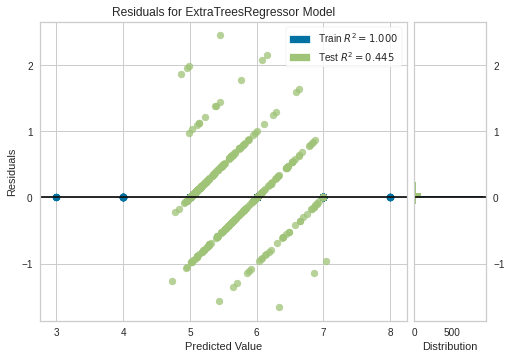

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [30]:
# check the residuals of trained model
plot_model(best, plot = 'residuals')

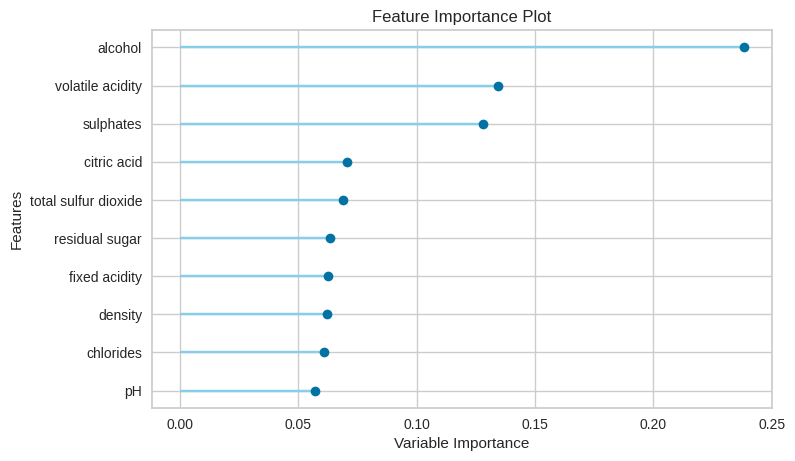

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [31]:
# check feature importance
plot_model(best, plot = 'feature')

In [ ]:
# finalize the model
final_best = finalize_model(best)

# save model to disk
save_model(final_best, 'wine-pipeline')

In [33]:
from pycaret.classification import load_model 

wine_regression = load_model('wine-pipeline') 
wine_regression

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=wine-pipeline, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='quality',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                     criterion='mse', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     max_samples=None,
                                     min_impurity_de

In [34]:
## now using unseen data 

# now as the model is a pipeline, this can easily be done!

unseen_prediction = predict_model(wine_regression, data =  test_df)
unseen_prediction.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='quality',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                     criterion='mse', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                  

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3744,0.3036,0.551,0.5576,0.0834,0.0677


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Label
6,7.9,0.600,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,5.10
8,7.8,0.580,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,5.51
10,6.7,0.580,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5,5.35
12,5.6,0.615,0.00,1.6,0.089,16.0,59.0,0.9943,3.58,0.52,9.9,5,5.29
18,7.4,0.590,0.08,4.4,0.086,6.0,29.0,0.9974,3.38,0.50,9.0,4,5.16


In [40]:
from pycaret.utils import check_metric 

print(f" The test-MSE is { check_metric(unseen_prediction.quality   , unseen_prediction.Label, 'MSE') }")
print(f" The test-MAE is { check_metric(unseen_prediction.quality   , unseen_prediction.Label, 'MAE') }")
print(f" The test-R2 is { check_metric(unseen_prediction.quality   , unseen_prediction.Label, 'R2') }")


 The test-MSE is 0.3036
 The test-MAE is 0.3744
 The test-R2 is 0.5576
